In [1]:
"""
Source1: https://github.com/lbarazza/VPG-PyTorch/blob/master/vpg.py
Source2: https://github.com/mitchellvitez/vanilla-policy-gradient/blob/main/vpg.py
"""

'\nSource1: https://github.com/lbarazza/VPG-PyTorch/blob/master/vpg.py\nSource2: https://github.com/mitchellvitez/vanilla-policy-gradient/blob/main/vpg.py\n'

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

num_episodes = 50
num_rollouts = 50
discount_factor = 0.99 
max_T = 500

In [3]:
class Network(nn.Module):
    def __init__(self): 
        super(Network, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(self.fc2(x))
        return x

my_network = Network()

optimizer = torch.optim.Adam(my_network.parameters(), lr=0.05)

In [4]:
def discounted_reward(max_T, start_t, rewards, discount_factor=0.99):
    return np.sum(np.full(max_T - start_t, discount_factor) ** np.arange(max_T - start_t) * np.array(rewards[start_t:]))

def run():
    
    reward_history = []

    env = gym.make('CartPole-v1')

    for episode_id in range(num_episodes):

        rewards = np.zeros((num_rollouts, max_T))
        deriv = torch.zeros((num_rollouts, max_T, 4))

        optimizer.zero_grad()

        for rollout_id in range(num_rollouts): # i in eqns

            observation = env.reset()
            cum_reward = 0
                        
            for t in range(max_T):

                output = my_network(torch.FloatTensor(observation)) # prob. of selecting action as 1
                
                action = np.random.binomial(1, output.detach().numpy(), 1)[0]
                
                new_observation, reward, done, info = env.step(action)

                rewards[rollout_id, t] = reward
                
                # TODO: Effect of random variable X ?
                if action == 0: # x = 0
                    deriv[rollout_id, t] = -output * torch.Tensor(observation)
                elif action == 1: # x = 1
                    deriv[rollout_id, t] = (1-output) * torch.Tensor(observation)

                observation = new_observation

                if done:
                    break
                else:
                    cum_reward += reward

            reward_history.append(cum_reward)
        
        discounted_rewards = np.zeros_like(rewards)
        
        for rollout_id in range(num_rollouts):
            for t in range(max_T):
                discounted_rewards[rollout_id, t] = discounted_reward(max_T = max_T, start_t = t, rewards=rewards[rollout_id], discount_factor=discount_factor)
            
            # calculate discounted reward for each timestep t
            #discounted_rewards[rollout_id] = np.full(max_T, discount_factor) ** np.arange(max_T) * np.array(rewards[rollout_id])
            
            # Reverse then cumulative sum bcs we want cumulative sum after timestep t
            #discounted_rewards[rollout_id] = discounted_rewards[rollout_id][::-1].cumsum()[::-1]

        baseline = np.mean(discounted_rewards, axis=0)

        # TODO: Vector implementation ??
        loss = torch.zeros((4))
        for rollout_id in range(num_rollouts):
            for t in range(max_T):
                current_loss = torch.mul(deriv[rollout_id, t], (discounted_rewards[rollout_id, t] - baseline[t]))
                #print(current_loss)
                loss += current_loss

        loss /= num_rollouts

        loss = -torch.mean(loss)

        print("Episode: {} | Loss: {} | Avg. Cum. Reward: {}".format(episode_id, loss, np.mean(reward_history[-num_rollouts:])))

        
        loss.backward()
        optimizer.step()

    env.close()

    return reward_history

def moving_average(a, n=3) :
    """
    from:
    https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Episode: 0 | Loss: -0.9264669418334961 | Avg. Cum. Reward: 18.54
Episode: 1 | Loss: -1.8413281440734863 | Avg. Cum. Reward: 22.24
Episode: 2 | Loss: -1.6376771926879883 | Avg. Cum. Reward: 25.26
Episode: 3 | Loss: -1.1200722455978394 | Avg. Cum. Reward: 27.3
Episode: 4 | Loss: -1.6367905139923096 | Avg. Cum. Reward: 29.68
Episode: 5 | Loss: -2.6023852825164795 | Avg. Cum. Reward: 34.42
Episode: 6 | Loss: -3.611929416656494 | Avg. Cum. Reward: 35.62
Episode: 7 | Loss: -3.767796039581299 | Avg. Cum. Reward: 40.04
Episode: 8 | Loss: -3.3066515922546387 | Avg. Cum. Reward: 46.36
Episode: 9 | Loss: -8.624364852905273 | Avg. Cum. Reward: 55.78
Episode: 10 | Loss: -4.303363800048828 | Avg. Cum. Reward: 48.2
Episode: 11 | Loss: -2.946065902709961 | Avg. Cum. Reward: 52.94
Episode: 12 | Loss: -1.8655999898910522 | Avg. Cum. Reward: 54.24
Episode: 13 | Loss: -2.8737025260925293 | Avg. Cum. Reward: 56.22
Episode: 14 | Loss: -4.82728385925293 | Avg. Cum. Reward: 63.04
Episode: 15 | Loss: -3.227150

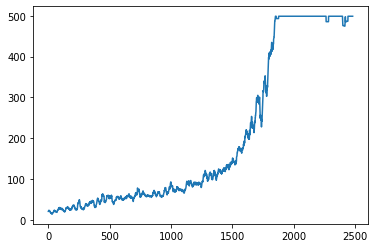

In [5]:
reward_hist = run()
plt.plot(moving_average(reward_hist, 20))
plt.show()